# PyTorch model

In [1]:
import os
import torch
from torch import nn
import torch.nn.functional as F
import lightning as L
import pandas as pd
import xarray as xr
import csv

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from brokenaxes import brokenaxes
import warnings 
import tqdm
warnings.filterwarnings("ignore")

In [3]:
from SproutDataset import SproutDataset
from Augmentation import Augmentation
from Sprout_ML import Sprout_ML, interpolate_arrays

In [4]:
import wandb
import torchvision

In [5]:
from lightly.loss import NegativeCosineSimilarity
from lightly.models.modules import SimSiamPredictionHead, SimSiamProjectionHead
from lightly.transforms import SimSiamTransform

In [6]:
from torch.utils.data import DataLoader
BATCH_SIZE = 32

# Tests classes and first run of model

In [7]:
import random

In [8]:
datasetNone = SproutDataset(augmentation_type=None)
datasetsingle = SproutDataset(augmentation_type='single')
datasetdouble = SproutDataset(augmentation_type='double')
item = datasetNone.__getitem__(75)  ## or item = datasetNone(75)

In [ ]:
datasetmini = xr.open_dataset("C:\\Users\\tania\\Documents\\SPICE\\SPROUTS\\spectra_train_mini.nc")

In [23]:
str(datasetmini.isel(index=75)['filename'].data)
print(datasetmini.isel(index=760)['x-index'].data, datasetmini.isel(index=75)['y-index'].data)

3 75


In [25]:
from sunraster.instr.spice import read_spice_l2_fits 

In [34]:
def map_item_map(item_nbr, dataset, plot=False, data_dir='C:\\Users\\tania\\Documents\\SPICE\\SPROUTS\\data_L2\\', key='Ne VIII 770 (Merged)',croplatbottom=725, croplattop=115):
    filename = str(dataset.isel(index=item_nbr)['filename'].data)
    i,j = (dataset.isel(index=item_nbr)['x-index'].data, dataset.isel(index=item_nbr)['y-index'].data)
    exposure = read_spice_l2_fits(data_dir+filename, memmap=False)
    cube = exposure[key][0,:,croplattop:croplatbottom,:].data
    if plot:
        plt.imshow(cube[20, :, :], aspect=1/4, cmap='gist_heat', vmax=np.nanquantile(cube[20, :, :], 0.999))
        plt.plot(i, j, color='yellow', marker='+')

In [49]:
len(datasetmini.isel()['index'])

117120

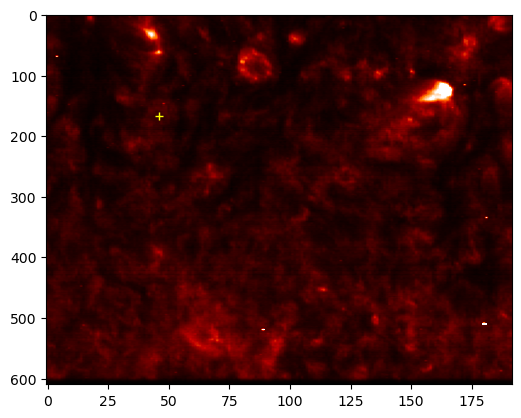

In [50]:
map_item_map(8999, datasetmini, plot=True)

## Dataloader

In [70]:
# dataset_path = "C:\\Users\\tania\\Documents\\SPICE\\SPROUTS\\spectra_train_mini.nc"
dataset_path = "C:\\Users\\tania\\Documents\\SPICE\\SPROUTS\\spectra_train_mini.nc"
datasetsingle = SproutDataset(dataset_path=dataset_path, augmentation_type='single')
dataloader = DataLoader(
            datasetsingle,
            batch_size=BATCH_SIZE,
            shuffle=True)
print(len(datasetsingle.__getitem__(65)), datasetsingle.__getitem__(65)[0].shape, datasetsingle.__getitem__(65)[1].shape)

2 (451,) (451,)


In [25]:
# Call lighlty (but assumes an image but we have 1D signals)
# Check what architectures are popular for 1D data --> CNN? Physionet 2017

### Try 1 : CNN 1D
https://github.com/harryjdavies/Python1D_CNNs/blob/master/CCN1D_pytorch_activity.py

In [19]:
wandb.init(project="siamese-1st_try", entity="tava8993-boulder") 

epoch,▁▃▅▆█
loss,█▃▂▁▁
epoch,5
loss,1.80439


wandb: WARNING Fatal error while uploading data. Some run data will not be synced, but it will still be written to disk. Use `wandb sync` at the end of the run to try uploading.
Exception in thread ChkStopThr:
Traceback (most recent call last):
  File "c:\Users\tania\anaconda3\envs\pytorch-env\Lib\threading.py", line 1075, in _bootstrap_inner
    self.run()
  File "c:\Users\tania\anaconda3\envs\pytorch-env\Lib\site-packages\ipykernel\ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "c:\Users\tania\anaconda3\envs\pytorch-env\Lib\threading.py", line 1012, in run
    self._target(*self._args, **self._kwargs)
  File "c:\Users\tania\anaconda3\envs\pytorch-env\Lib\site-packages\wandb\sdk\wandb_run.py", line 305, in check_stop_status
    self._loop_check_status(
  File "c:\Users\tania\anaconda3\envs\pytorch-env\Lib\site-packages\wandb\sdk\wandb_run.py", line 235, in _loop_check_status
    local_handle = request()
                   ^^^^^^^^^
  File "c:\Users\tania

In [24]:
class Siamese1DNet(nn.Module):
    def __init__(self):
        super(Siamese1DNet, self).__init__()
        
        
        # Shared feature extraction network
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm1d(32)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(64)
        self.pool = nn.MaxPool1d(kernel_size=2)
        
        # Fully connected layers for embeddings
        self.fc1 = nn.Linear(7168, 128)   ## remove those? Can also keep
        self.fc2 = nn.Linear(128, 64)  
        self.fc3 = nn.Linear(64, 2)      # Output constrained to size 2

    def forward_once(self, x):
        # Feature extraction
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # Final layer to constrain output to size 2
        return F.normalize(x, dim=1)
    
    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2


In [25]:
# loss function: NT-Xent Loss. Commonly used in self-supervised learning methods like SimCLR. It measures the cosine similarity between embeddings.
class NTXentLoss(nn.Module):
    def __init__(self, temperature=0.5):
        super(NTXentLoss, self).__init__()
        self.temperature = temperature
        self.similarity = nn.CosineSimilarity(dim=-1)
    
    def forward(self, z_i, z_j):
        # Normalize embeddings
        z_i = F.normalize(z_i, dim=1)
        z_j = F.normalize(z_j, dim=1)
        
        # Compute similarity
        positives = self.similarity(z_i, z_j)
        negatives = torch.mm(z_i, z_j.T)  # All pairs
        
        # Remove self-comparisons
        batch_size = z_i.size(0)
        mask = torch.eye(batch_size, device=z_i.device).bool()
        negatives.masked_fill_(mask, -float('inf'))
        
        # Compute logits
        logits = torch.cat([positives.unsqueeze(1), negatives], dim=1)
        logits /= self.temperature
        
        # Labels for positives
        labels = torch.zeros(batch_size, dtype=torch.long, device=z_i.device)
        loss = F.cross_entropy(logits, labels)
        return loss


In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_EPOCHS = 5

In [ ]:
# # Training loop
# model = Siamese1DNet().to(device)
# criterion = NTXentLoss(temperature=0.5)
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# wandb.watch(model, log="all", log_freq=10)
# for epoch in range(NUM_EPOCHS):
#     model.train()  # Set model to training mode
#     epoch_loss = 0.0
    
#     for batch in dataloader:
#         # Assuming the dataloader returns (augmentation1, augmentation2)
#         input1, input2 = batch
#         input1 = input1.unsqueeze(1)  # Add channel dimension: [batch_size, 1, length]
#         input2 = input2.unsqueeze(1)
#         input1, input2 = input1.to(device).float(), input2.to(device).float()  # Move to device
        
#         # Forward pass
#         output1, output2 = model(input1, input2)
        
#         # Compute loss
#         loss = criterion(output1, output2)
        
#         # Backward pass and optimization
#         optimizer.zero_grad()
#         loss.backward() ## compute gradients and update weights
#         optimizer.step()
        
#         epoch_loss += loss.item()
#     avg_loss = epoch_loss / len(dataloader)
#     print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Loss: {epoch_loss/len(dataloader):.4f}")
#     wandb.log({"epoch": epoch + 1, "loss": avg_loss})
# wandb.save("siamese-1st_try.pth")

Epoch [1/5], Loss: 2.4330
Epoch [2/5], Loss: 2.3688
Epoch [3/5], Loss: 2.3620
Epoch [4/5], Loss: 2.3590
Epoch [5/5], Loss: 2.3557


[]

In [29]:
model = Siamese1DNet().to(device)
criterion = NTXentLoss(temperature=0.5)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
wandb.watch(model, log="all", log_freq=10)

outputs_collected = []

for epoch in range(NUM_EPOCHS):
    model.train()  # Set model to training mode
    epoch_loss = 0.0

    for batch in dataloader:
        # Assuming the dataloader returns (augmentation1, augmentation2)
        input1, input2 = batch
        input1 = input1.unsqueeze(1)  # Add channel dimension: [batch_size, 1, length]
        input2 = input2.unsqueeze(1)
        input1, input2 = input1.to(device).float(), input2.to(device).float()  # Move to device
        
        # Forward pass
        output1, output2 = model(input1, input2)

        # Collect outputs during training (optional)
        if epoch == NUM_EPOCHS - 1:  # Collect only for the last epoch
            outputs_collected.append((output1.detach().cpu(), output2.detach().cpu()))

        # Compute loss
        loss = criterion(output1, output2)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward() #compute gradients and update weights
        optimizer.step()
        
        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(dataloader)
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Loss: {epoch_loss/len(dataloader):.4f}")
    wandb.log({"epoch": epoch + 1, "loss": avg_loss})

# Save the model
torch.save(model.state_dict(), "siamese-1st_try.pth")

# Combine outputs collected during the last epoch
output1_all, output2_all = zip(*outputs_collected)
output1_all = torch.cat(output1_all)
output2_all = torch.cat(output2_all)

Epoch [1/5], Loss: 2.4354
Epoch [2/5], Loss: 2.3676
Epoch [3/5], Loss: 2.3612
Epoch [4/5], Loss: 2.3584
Epoch [5/5], Loss: 2.3569


In [38]:
# Convert to numpy
output1_np = output1_all.numpy()
output2_np = output2_all.numpy()
combined_outputs = np.vstack((output1_np, output2_np))

In [40]:
combined_outputs.shape

(234240, 2)

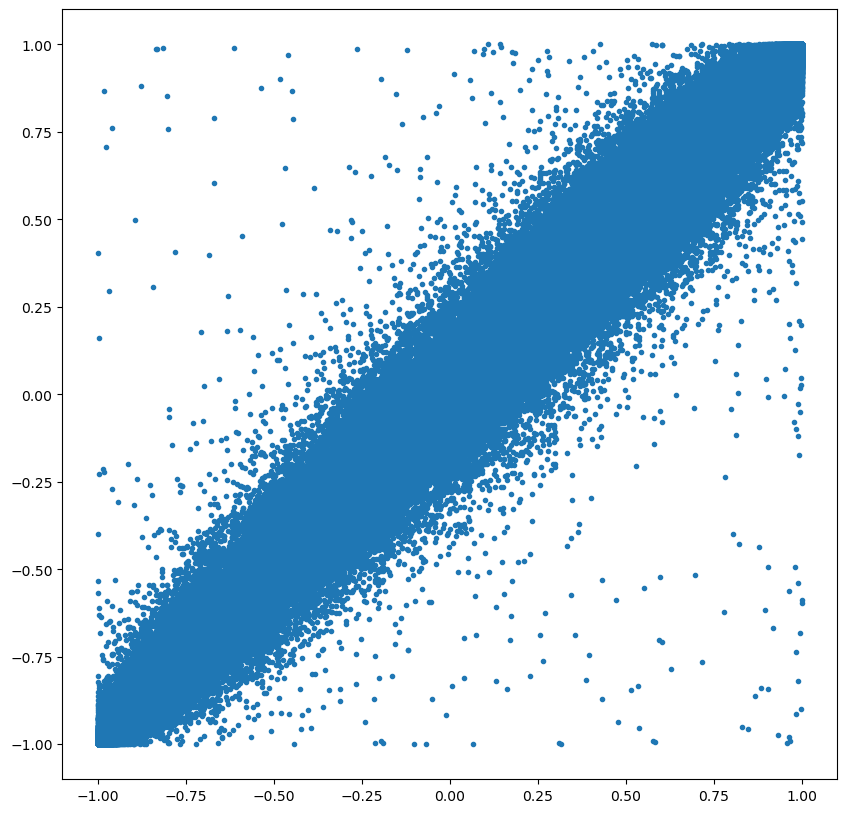

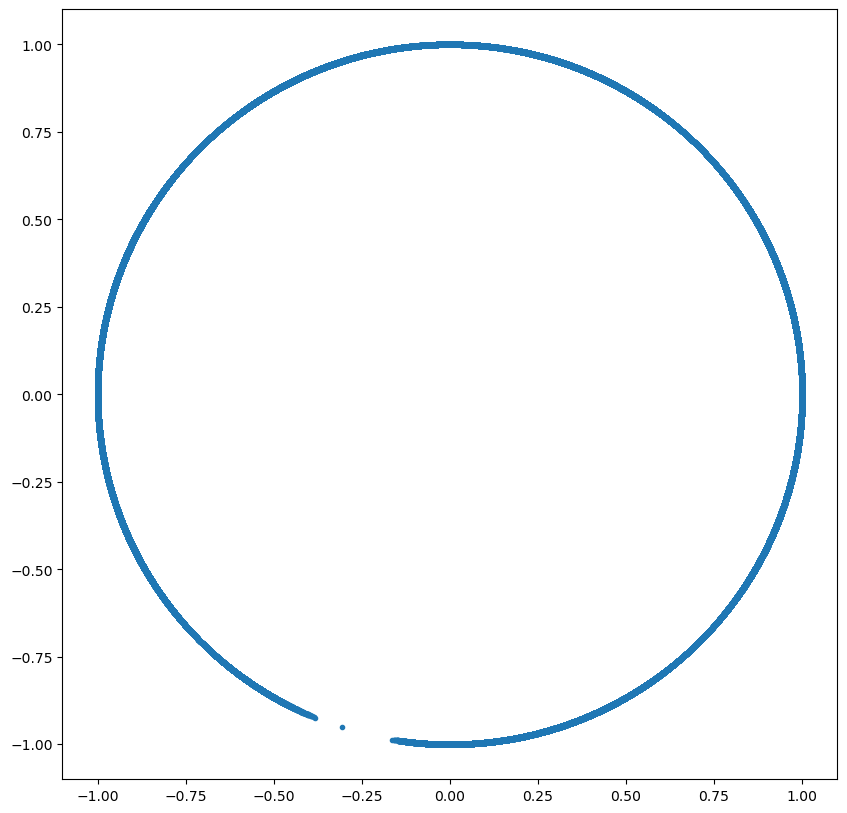

In [39]:
plt.figure(figsize=(10,10))
plt.scatter(output1_np, output2_np, marker='.')
plt.figure(figsize=(10,10))
plt.scatter(combined_outputs[:,0], combined_outputs[:,1], marker='.')

Similarity Scores: tensor([0.9977, 0.9622, 0.9985, 0.9617, 0.9992, 0.9990, 0.9995, 0.9998, 0.9947,
        1.0000, 0.9960, 0.9773, 0.9979, 0.9987, 0.9960, 0.9974, 1.0000, 1.0000,
        1.0000, 0.9982, 0.9986, 0.9996, 1.0000, 0.9903, 0.9989, 0.9997, 1.0000,
        0.9999, 0.9919, 1.0000, 0.9999, 0.9971], device='cuda:0',
       grad_fn=<SumBackward1>)


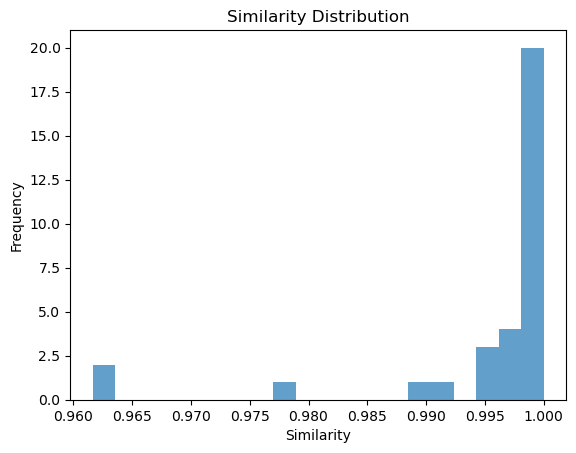

In [28]:
import torch.nn.functional as F

def compute_similarity(output1, output2):
    similarity = F.cosine_similarity(output1, output2)
    return similarity

# Example: Analyze a batch
for batch in dataloader:
    input1, input2 = batch
    input1, input2 = input1.to(device).float(), input2.to(device).float()
    output1, output2 = model(input1.unsqueeze(1), input2.unsqueeze(1))
    
    similarity = compute_similarity(output1, output2)
    print("Similarity Scores:", similarity)
    plt.hist(similarity.detach().cpu().numpy(), bins=20, alpha=0.7)
    plt.title("Similarity Distribution")
    plt.xlabel("Similarity")
    plt.ylabel("Frequency")
    plt.show()
    break

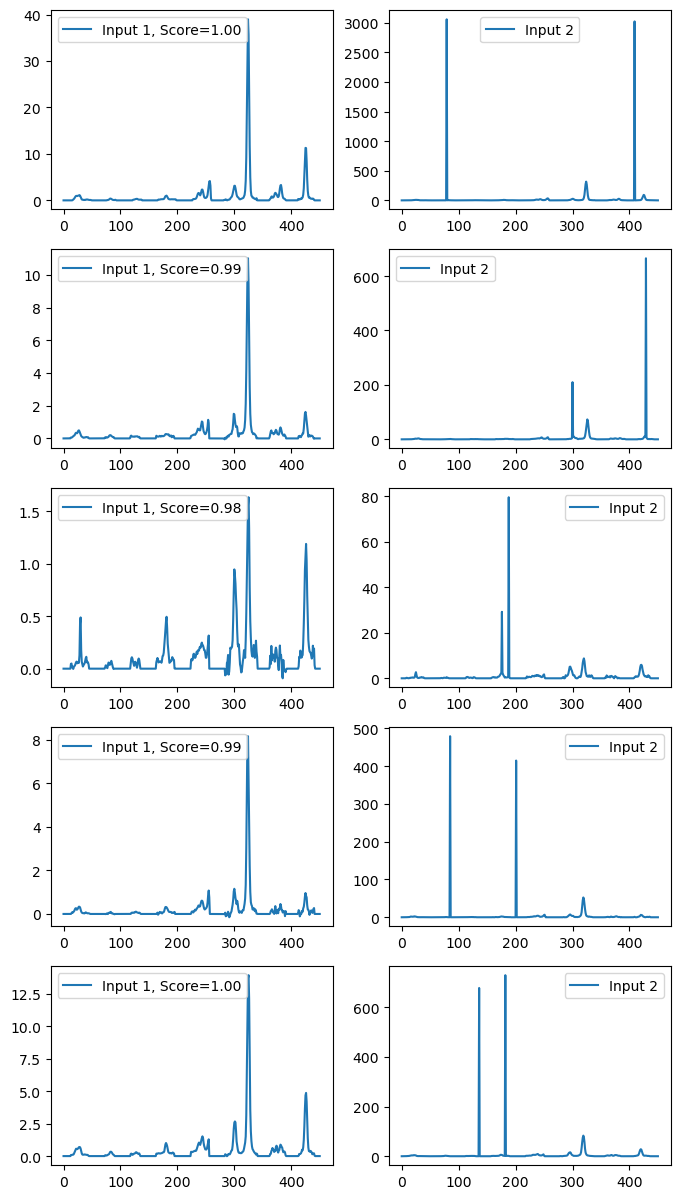

In [73]:
def visualize_pairs(input1, input2, similarity_scores):
    num_pairs = min(len(input1), 5)  # Visualize 5 pairs
    input1, input2 = input1.cpu().numpy(), input2.cpu().numpy()
    
    fig, axs = plt.subplots(num_pairs, 2, figsize=(8, num_pairs * 3))
    for i in range(num_pairs):
        axs[i, 0].plot(input1[i], label=f"Input 1, Score={similarity_scores[i]:.2f}")
        axs[i, 0].legend()
        axs[i, 1].plot(input2[i], label="Input 2")
        axs[i, 1].legend()
    plt.show()

# Example: Visualize a batch
for batch in dataloader:
    input1, input2 = batch
    input1, input2 = input1.to(device).float(), input2.to(device).float()
    output1, output2 = model(input1.unsqueeze(1), input2.unsqueeze(1))
    similarity = compute_similarity(output1, output2)
    
    visualize_pairs(input1, input2, similarity.detach().cpu().numpy())
    break

In [63]:
datasetsingle.__len__()

1171200

----------------------------------------------------

----------------------------------------------------

----------------------------------------------------

In [43]:
class Siamese1DNet_64dim(nn.Module):
    def __init__(self):
        super(Siamese1DNet_64dim, self).__init__()
        
        
        # Shared feature extraction network
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm1d(32)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(64)
        self.pool = nn.MaxPool1d(kernel_size=2)
        
        # Fully connected layers for embeddings
        self.fc1 = nn.Linear(7168, 128)   ## remove those? Can also keep
        self.fc2 = nn.Linear(128, 64)      # Output constrained to size 2

    def forward_once(self, x):
        # Feature extraction
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return F.normalize(x, dim=1)
    
    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

In [44]:
model = Siamese1DNet_64dim().to(device)
criterion = NTXentLoss(temperature=0.5)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
wandb.watch(model, log="all", log_freq=10)

outputs_collected = []
NUM_EPOCHS = 10
for epoch in range(NUM_EPOCHS):
    model.train()  # Set model to training mode
    epoch_loss = 0.0

    for batch in dataloader:
        # Assuming the dataloader returns (augmentation1, augmentation2)
        input1, input2 = batch
        input1 = input1.unsqueeze(1)  # Add channel dimension: [batch_size, 1, length]
        input2 = input2.unsqueeze(1)
        input1, input2 = input1.to(device).float(), input2.to(device).float()  # Move to device
        
        # Forward pass
        output1, output2 = model(input1, input2)

        # Collect outputs during training (optional)
        if epoch == NUM_EPOCHS - 1:  # Collect only for the last epoch
            outputs_collected.append((output1.detach().cpu(), output2.detach().cpu()))

        # Compute loss
        loss = criterion(output1, output2)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward() #compute gradients and update weights
        optimizer.step()
        
        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(dataloader)
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Loss: {epoch_loss/len(dataloader):.4f}")
    wandb.log({"epoch": epoch + 1, "loss": avg_loss})

# Save the model
torch.save(model.state_dict(), "siamese-1st_try.pth")

# Combine outputs collected during the last epoch
output1_all, output2_all = zip(*outputs_collected)
output1_all = torch.cat(output1_all)
output2_all = torch.cat(output2_all)

Epoch [1/10], Loss: 2.4102
Epoch [2/10], Loss: 2.2097
Epoch [3/10], Loss: 2.1004
Epoch [4/10], Loss: 2.0507
Epoch [5/10], Loss: 1.9919
Epoch [6/10], Loss: 1.9840
Epoch [7/10], Loss: 1.9643
Epoch [8/10], Loss: 1.9470
Epoch [9/10], Loss: 1.9439
Epoch [10/10], Loss: 1.9315


In [47]:
output1_np_64 = output1_all.numpy()
output2_np_64 = output2_all.numpy()
output1_np_64.shape

(117120, 64)

In [61]:
import umap.umap_ as umap

TypeError: hist2d() missing 1 required positional argument: 'y'

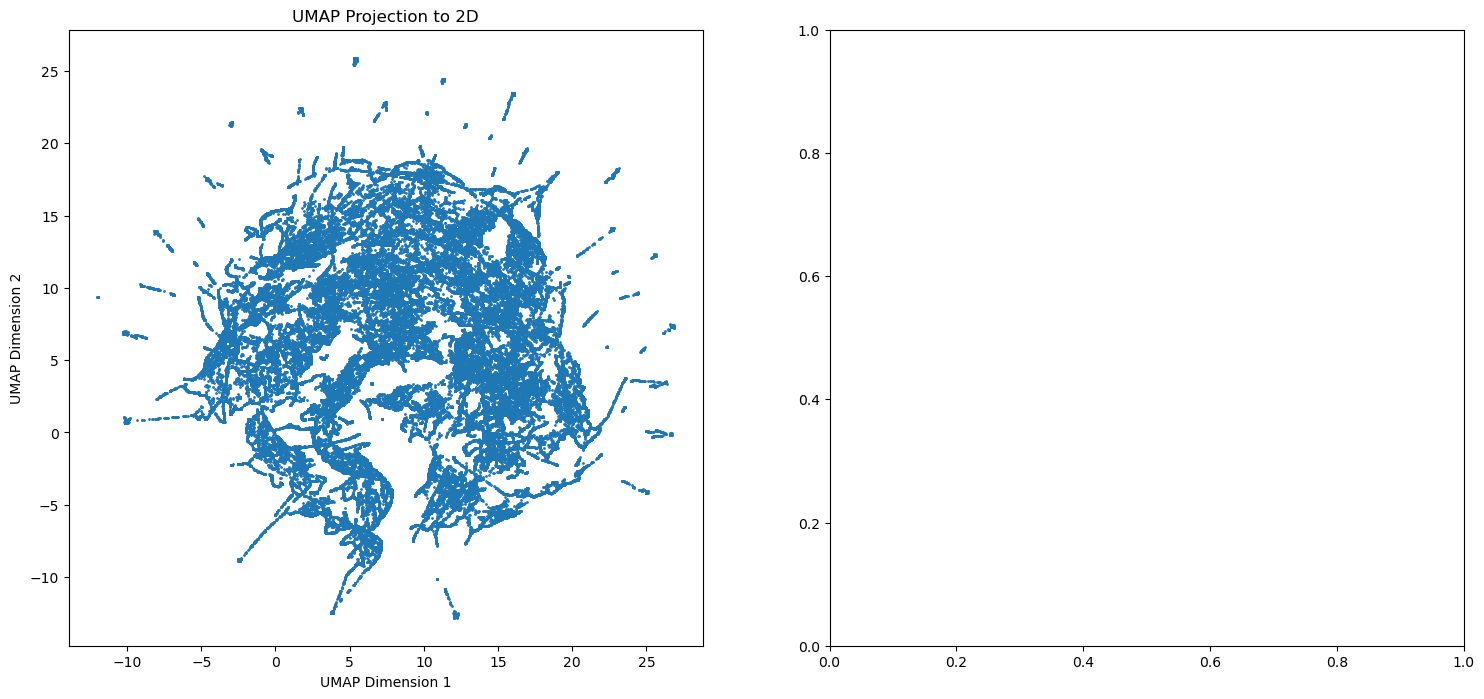

In [75]:
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
embedding = reducer.fit_transform(output1_np_64)

In [81]:
output1_np_64.shape

Error in callback <bound method _WandbInit._resume_backend of <wandb.sdk.wandb_init._WandbInit object at 0x000001B6EE32CDA0>> (for pre_run_cell), with arguments args (<ExecutionInfo object at 1b721f69c70, raw_cell="output1_np_64.shape" store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/c%3A/Users/tania/Documents/CU%20Boulder/CU%20Fall%202024/ASEN%206337/Individual%20project/SPICE_DeepLearning/PyTorch_model.ipynb#Y120sZmlsZQ%3D%3D>,),kwargs {}:


ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host

(117120, 64)

Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x000001B6EE32CDA0>> (for post_run_cell), with arguments args (<ExecutionResult object at 1b721f68c80, execution_count=81 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 1b721f69c70, raw_cell="output1_np_64.shape" store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/c%3A/Users/tania/Documents/CU%20Boulder/CU%20Fall%202024/ASEN%206337/Individual%20project/SPICE_DeepLearning/PyTorch_model.ipynb#Y120sZmlsZQ%3D%3D> result=(117120, 64)>,),kwargs {}:


ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host

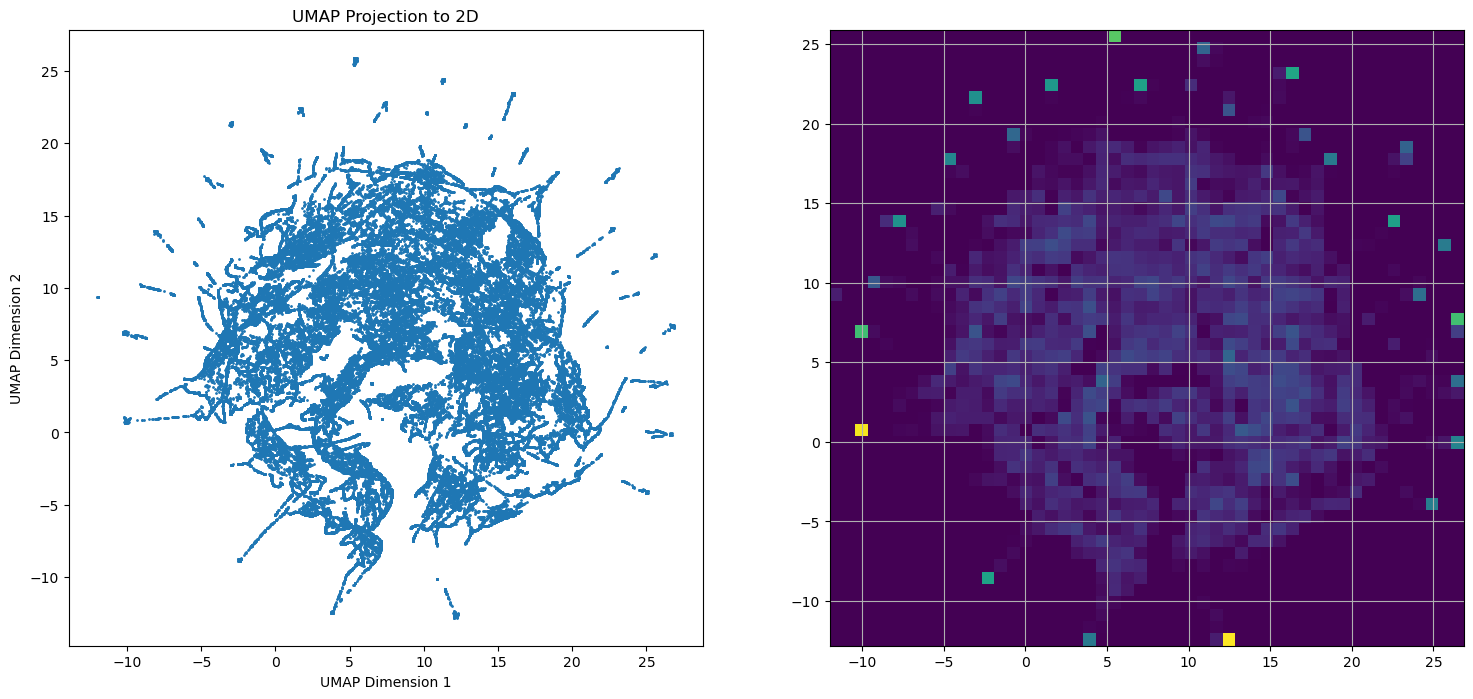

In [79]:
# Plotting the 2D UMAP embedding AND 2D HISTOGRAM
plt.figure(figsize=(18, 8))
plt.subplot(121)
scatter = plt.scatter(embedding[:, 0], embedding[:, 1], cmap='Spectral', s=1)
plt.title('UMAP Projection to 2D')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.subplot(122)
plt.hist2d(embedding[:, 0], embedding[:, 1], bins=50)
plt.grid(True)
plt.show()

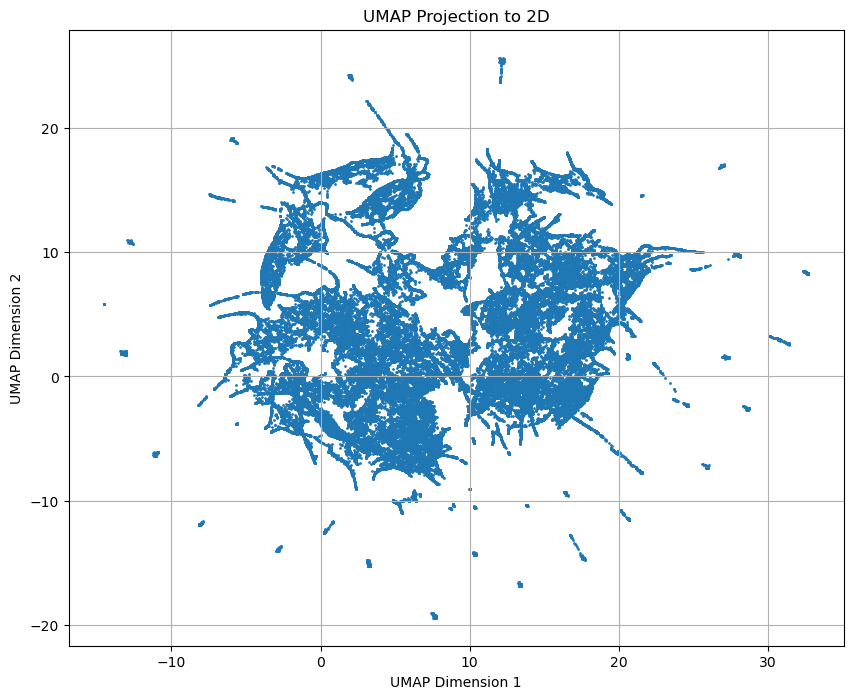

In [71]:
reducer = umap.UMAP(n_neighbors=30, min_dist=0.1, n_components=2, random_state=42)
embedding = reducer.fit_transform(output1_np_64)

# Plotting the 2D UMAP embedding
plt.figure(figsize=(10, 8))
scatter = plt.scatter(embedding[:, 0], embedding[:, 1], cmap='Spectral', s=1)
plt.title('UMAP Projection to 2D')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.grid(True)
plt.show()

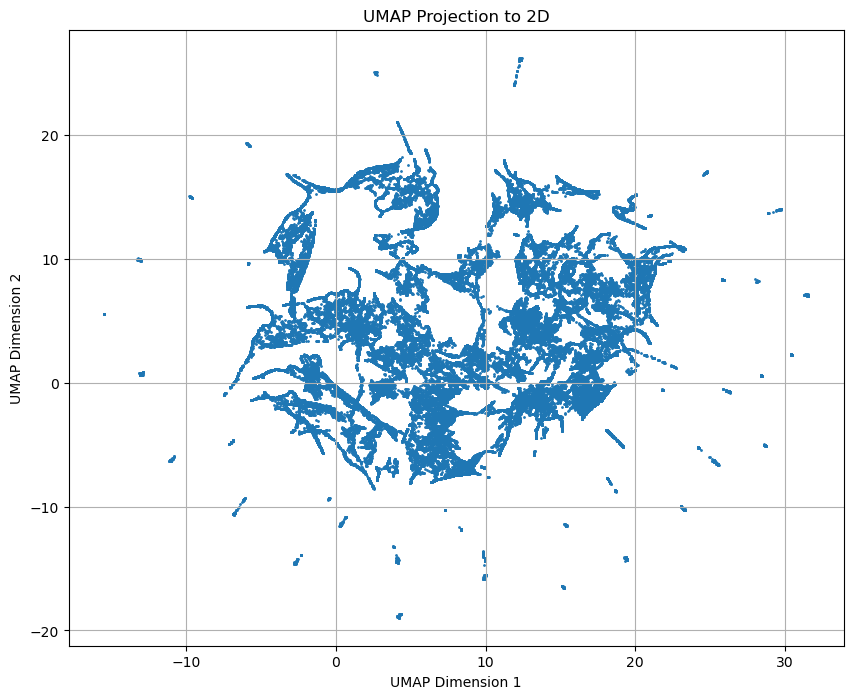

In [74]:
reducer = umap.UMAP(n_neighbors=30, min_dist=0.01, n_components=2, random_state=42)
embedding = reducer.fit_transform(output1_np_64)

# Plotting the 2D UMAP embedding
plt.figure(figsize=(10, 8))
scatter = plt.scatter(embedding[:, 0], embedding[:, 1], cmap='Spectral', s=1)
plt.title('UMAP Projection to 2D')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.grid(True)
plt.show()

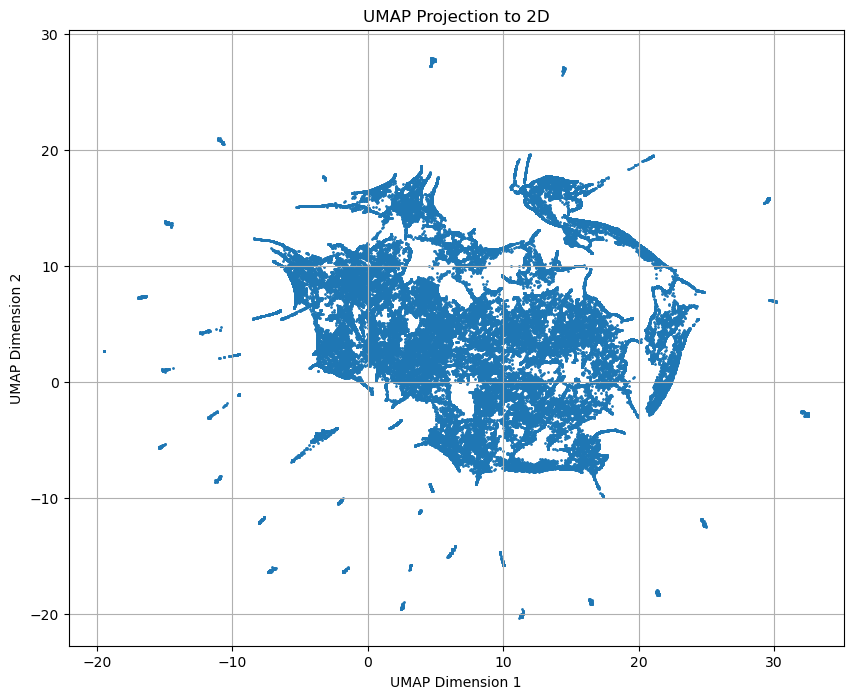

In [72]:
reducer = umap.UMAP(n_neighbors=50, min_dist=0.1, n_components=2, random_state=42)
embedding = reducer.fit_transform(output1_np_64)

# Plotting the 2D UMAP embedding
plt.figure(figsize=(10, 8))
scatter = plt.scatter(embedding[:, 0], embedding[:, 1], cmap='Spectral', s=1)
plt.title('UMAP Projection to 2D')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.grid(True)
plt.show()

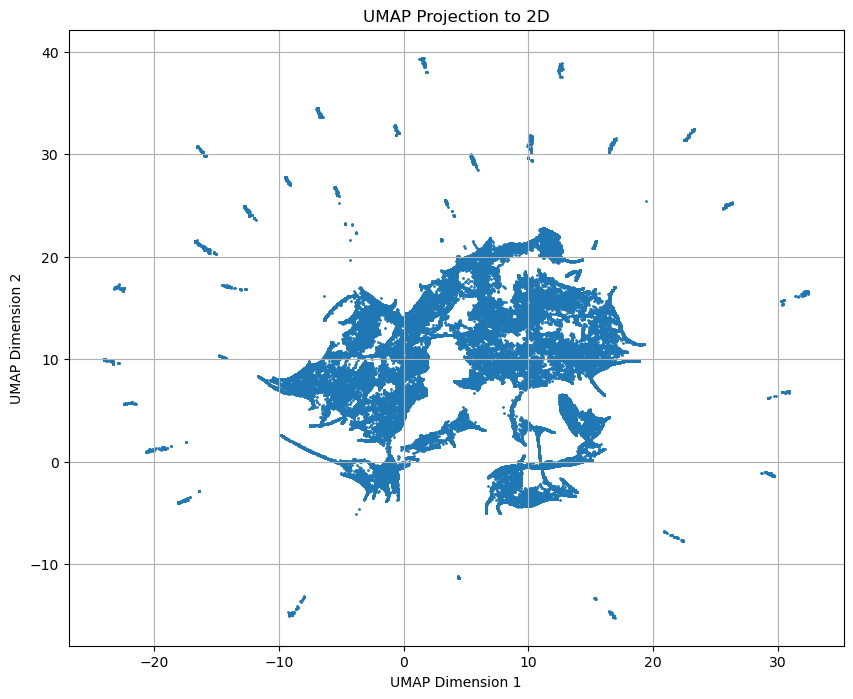

In [73]:
reducer = umap.UMAP(n_neighbors=100, min_dist=0.1, n_components=2, random_state=42)
embedding = reducer.fit_transform(output1_np_64)

# Plotting the 2D UMAP embedding
plt.figure(figsize=(10, 8))
scatter = plt.scatter(embedding[:, 0], embedding[:, 1], cmap='Spectral', s=1)
plt.title('UMAP Projection to 2D')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.grid(True)
plt.show()

----------------------------------------------------------

--------------------------------------------------------------------

Self-supervised search: run infidence on the backbone+projection head

Feed the spectra thu the backbone, then backbone to proj head. Give 128 values. Encoding spectra to vector of size 128.
End up with vector for each one of the spectra. 

Take those 128 values for all spectra, and pass them to Umap. Turn 128 values to (x,y) coordinates.

Use (H)DBScan to cluster the 2D output

Go through files, each pixel will be numbered according to the cluster. Vizualize the files (rasters) with a categorial colomap.

Once clustering is done, assess index to cluster number and then can make maps!